# <ins>Predicting Poetic Movements</ins>

## Recommendation system

- In this notebook, I build the basis for a [poetry recommender](https://evening-cove-11137.herokuapp.com/) using my engineered features and Doc2Vec document embeddings.
- I then test my functions and a custom filter based on my engineered features. 
- Finally, I visualize the poem vectors using t-SNE to reduce dimensionality.

## Table of contents

1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Preparing the data](#Step-1:-Preparing-the-data)
    
    - [Calculating similarities](#Calculating-similarities)
    
    
5. [Step 2: Testing functions](#Step-2:-Testing-functions)

    - [Word similarity](#Word-similarity)
    - [Phrase similarity](#Phrase-similarity)
    - [Poem similarity](#Poem-similarity)
    - [Filter](#Filter)
    
    
6. [Step 3: Visualizing similarities](#Step-3:-Visualizing-similarities)

    - [Two dimensions](#Two-dimensions)
        - [By movement](#Two-dimensions----by-movement) | [By genre](#Two-dimensions----by-genre)
    - [Three dimensions](#Three-dimensions)
        - [By movement](#Three-dimensions----by-movement) | [By genre](#Three-dimensions----by-genre)


7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](#Predicting-Poetic-Movements)]

After [scraping](01_webscraping.ipynb) PoetryFoundation.org for genre-labeled poems and [cleaning](02_data_cleaning.ipynb), I used [natural language processing (NLP)](03_nlp_features_eda.ipynb) techniques to analyze poetic structure across poetic genres and movements. 

Through text processing, exploratory data analysis, and feature engineering, I looked for insights into how poetic structure, word usage, lexical richness, and sentiment relate to the movement of a poem.

Then I created predictive [models](04_modeling.ipynb) that classify poems into one of four umbrella movements: *Avant-Garde*, *Metropolitan*, *Modern*, or *Pre-1900*. This provided further insight and confirmation of my findings during EDA.

In this notebook, I'll create a recommendation system that compares poem similarities and recommends individual poems to users.

## The problem domain

[[go back to the top](#Predicting-Poetic-Movements)]

Within written media, poetry is often regarded as enigmatic, frivolous, or too niche. As a result, poems (even by established poets) are often overlooked by larger publishers and literature-focused websites alike. (The anti-capitalist nature of poetry may play a role here as well). There are services for rating and recommending entire books (including poetry collections, to be fair) like GoodReads, Amazon, or Bookish, but to my knowledge, there aren't any sites or services that recommend poems on an individual level.

With this in mind, I wondered how poem recommendation may even work. One often finds a genre or two that they like and searches that out, but there must be elements of poetry that transcend genre. If there are, machine learning seems like a perfect tool to use to find them. As a poet and writer, I am interested in creating something that will allow me to discover genres and movements that I may have previously ignored. I can do this by using poems I already know and enjoy to find similar poems from genres I may not know as well.

## Required libraries

[[go back to the top](#Predicting-Poetic-Movements)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. Libraries within this category that I'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **scikit-learn**: The essential Machine Learning package in Python.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages that you may have to install:
- **gensim**: A more specialized natural language processing package.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that I built for EDA and modeling in this project.
- **[functions_rec_system](functions_rec_system.py)**: Custom functions that I built for the recommendation system portion of this project.

Required for the function used in the functions.py file are:
- **nltk**: The essential natural language processing package.
- **regex**: The essential string matching and capturing package.
- **string**: A package with string-specific operations and characters.

In [1]:
# custom functions for this project
from functions import simple_process
from functions_rec_system import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')

# rec system libraries
from gensim.models.doc2vec import Doc2Vec
from sklearn.manifold import TSNE

# miscellany
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Step 1: Preparing the data

[[go back to the top](#Predicting-Poetic-Movements)]

- Import necessary data.
- Calculate similarities.
- Save list.

In [2]:
# load poetry dataframe
with gzip.open('data/poetry_movements_df_capped.pkl', 'rb') as hello:
    df_poems = pickle.load(hello)

# load doc2vec dataframe
with gzip.open('data/features_doc2vec_df.pkl', 'rb') as hello:
    df_docvec = pickle.load(hello)
    
# load doc2vec model
model = Doc2Vec.load('data/doc2vec_final.model')

- I only need certain information from the poem data, so I'll grab that here and save it.

In [3]:
df = df_poems[['poet', 'title', 'poem_url', 'genre']]
df.head()

,poet,title,poem_url,genre
0,Allen Ginsberg,A Supermarket in California,https://www.poetryfoundation.org/poems/47660/a...,beat
1,Allen Ginsberg,America,https://www.poetryfoundation.org/poems/49305/a...,beat
2,Allen Ginsberg,Footnote to Howl,https://www.poetryfoundation.org/poems/54163/f...,beat
3,Allen Ginsberg,Homework,https://www.poetryfoundation.org/poems/49311/h...,beat
4,Allen Ginsberg,Howl,https://www.poetryfoundation.org/poems/49303/howl,beat


#### 💾 Save/Load poem info DataFrame

In [4]:
# # uncomment to save
# with gzip.open('data/poems_df_rec_system.pkl', 'wb') as goodbye:
#     pickle.dump(df, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/poems_df_rec_system.pkl', 'rb') as hello:
#     df = pickle.load(hello)

### Calculate similarities

[[go back to the top](#Predicting-Poetic-Movements)]

- I will use cosine similarity over Euclidean distance to measure poem similarities because magnitude is inluded within my poem vectors.
    - Similar poetry has similar themes and language, which should be picked up on by Doc2Vec embeddings. They also have formal and structural elements (the magnitude in this case), which should be further picked up by my engineered features.
    - By including those features within the poem vectors themselves, I allow a poem's vector angle to shift toward similar formal and structural elements. It is ideally a best of both worlds scenario.
- I'll use sklearn's ```cosine_similarity``` function to easily find the similarities between each poem's vector formed by the Doc2Vec embeddings plus my engineered features.

In [5]:
# similarities of all poems
all_similarities = cosine_similarity(df_docvec)

# length of a sample element in the list
print(f'Similarities calculated per poem: {len(all_similarities[0])}')

# a peek at the first 20 similarity percentages
all_similarities[0][:20]

Similarities calculated per poem: 4307


array([1.        , 0.26750924, 0.37194948, 0.26424223, 0.37244697,
       0.32656573, 0.32833627, 0.31945785, 0.12489334, 0.28922694,
       0.14081469, 0.1774409 , 0.17504456, 0.12481439, 0.12495613,
       0.13217637, 0.20114046, 0.12839381, 0.04746497, 0.14498362])

- Each element of the resulting list has a value for each poem, including 1.0 for itself, since the angle of the vectors is 0 (and the cosine of 0 is 1).

#### 💾 Save/Load precalculated similarities

In [6]:
# # uncomment to save
# with gzip.open('data/all_similarities_list.pkl', 'wb') as goodbye:
#     pickle.dump(all_similarities, goodbye, protocol=pickle.HIGHEST_PROTOCOL)

# # uncomment to load
# with gzip.open('data/all_similarities_list.pkl', 'rb') as hello:
#     all_similarities = pickle.load(hello)

#### Important note
- Since I want to make an app based on this, and the precalculated similarities file is 141 MB (too large to upload to Heroku), I needed to create a function that calculates the similarity within it.
    - This will take longer than using the file created above, as I will show in the next section.
    - To run this app more efficiently, you can use the precalculated similarites file and the precalculated version of the function also shown in the next section.
    
    
# Step 2: Testing functions

[[go back to the top](#Predicting-Poetic-Movements)]

- Test functions to return similar poems using a word, phrase, and poem as inputs.
- Test function that filters returned poems.

### Word similarity

[[go back to the top](#Predicting-Poetic-Movements)]

#### Known word
- Print top 5 most similar poems.

In [7]:
%%time

test = word_similarity('love', df, model, n=5, to_print=True)

----------------------------------------------------------------------------------------------------
39.2% match
TO KAAON IN GREEK by Ezra Pound
GENRE: Imagist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/12922/to-kaaon-in-greek
----------------------------------------------------------------------------------------------------
35.3% match
WILL YOU NOT STAY AWAY by Marion Strobel
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/14760/will-you-not-stay-away
----------------------------------------------------------------------------------------------------
34.2% match
THE REALISTS by Jean Starr Untermeyer
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/22631/the-realists-56d20d9c9c54b
----------------------------------------------------------------------------------------------------
33.5% match
SONNETS FROM THE PORTUGUESE 14: IF THOU MUST LOVE ME, LET IT BE FOR NOUGHT by Elizabeth Barrett Browning
GENRE: Victorian
URL: http

#### Unknown word
- Print error message.

In [8]:
test = word_similarity('iwdvsakdhfl', df, model, n=5, to_print=True)

I don't know that word; try again.


### Phrase similarity

[[go back to the top](#Predicting-Poetic-Movements)]

In [9]:
test = phrase_similarity("Trump Offers Baseless Theory of People in ‘Dark Shadows’ Behind Biden", 
                         df, model, n=5, to_print=True)

----------------------------------------------------------------------------------------------------
41.2% match
THE SPRINGTIME by Denise Levertov
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poems/42533/the-springtime
----------------------------------------------------------------------------------------------------
41.1% match
THEME IN YELLOW by Carl Sandburg
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/45041/theme-in-yellow
----------------------------------------------------------------------------------------------------
39.3% match
HOUSES by Laura Riding Jackson
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/16209/houses
----------------------------------------------------------------------------------------------------
38.7% match
CHICAGO by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30987/chicago-56d21474cc167
--------------------------------------------------------------

- Some very interesting results here! The similarities are somewhat mysterious, to be sure (much like the enigmatic nature of Doc2Vec dimensions themselves), but meaning can definitely be breathed into it.
- It's also interesting how the results change if I run the function again using the same phrase.

In [10]:
test = phrase_similarity("Trump Offers Baseless Theory of People in ‘Dark Shadows’ Behind Biden", 
                         df, model, n=5, to_print=True)

----------------------------------------------------------------------------------------------------
40.3% match
CHICAGO by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30987/chicago-56d21474cc167
----------------------------------------------------------------------------------------------------
40.0% match
HOUSES by Laura Riding Jackson
GENRE: Modern
URL: https://www.poetryfoundation.org/poetrymagazine/poems/16209/houses
----------------------------------------------------------------------------------------------------
39.9% match
THE SPRINGTIME by Denise Levertov
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poems/42533/the-springtime
----------------------------------------------------------------------------------------------------
39.7% match
THEME IN YELLOW by Carl Sandburg
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/45041/theme-in-yellow
--------------------------------------------------------------

- Because the function infers a document vector for the input phrase, which is a somewhat random process, the values for the vector will change each time the function is run.
- As a result, the returned poems will tend to be slightly different, but should remain fairly similar, as seen above. A lot of the same poems were returned, albeit in a different order.

### Poem similarity

[[go back to the top](#Predicting-Poetic-Movements)]

- First, I'll time the function that uses the list of precalculated similarities generated earlier.
- Then I'll compare that to the function that has to calculate the similarities for the input poem within it.

In [11]:
%%time

# test case with precalculated similarities
test = poem_similarity_precalculated(df.loc[139, 'title'], 
                                     df.loc[139, 'poet'], 
                                     df, 
                                     all_similarities, 
                                     to_print=True)

----------------------------------------------------------------------------------------------------
46.5% match
THE WORLD NARROWED TO A POINT by William Carlos Williams
GENRE: Imagist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/22755/the-world-narrowed-to-a-point
----------------------------------------------------------------------------------------------------
46.3% match
MR WARNER by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30993/mr-warner
----------------------------------------------------------------------------------------------------
45.6% match
UNTITLED by Aram Saroyan
GENRE: New York School 2nd Generation
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30962/poem-night-night-night
----------------------------------------------------------------------------------------------------
45.1% match
ILL BE HERE by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/

In [12]:
%%time 

# test case with app-ready function, i.e. without
# large precalculated similarities file
test = poem_similarity(df.loc[139, 'title'], 
                       df.loc[139, 'poet'], 
                       df, 
                       df_docvec, 
                       to_print=True)

----------------------------------------------------------------------------------------------------
46.5% match
THE WORLD NARROWED TO A POINT by William Carlos Williams
GENRE: Imagist
URL: https://www.poetryfoundation.org/poetrymagazine/poems/22755/the-world-narrowed-to-a-point
----------------------------------------------------------------------------------------------------
46.3% match
MR WARNER by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30993/mr-warner
----------------------------------------------------------------------------------------------------
45.6% match
UNTITLED by Aram Saroyan
GENRE: New York School 2nd Generation
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30962/poem-night-night-night
----------------------------------------------------------------------------------------------------
45.1% match
ILL BE HERE by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/

- The precalculated list function is much faster, but I think the other function will be fast enough on a Heroku site. Fingers crossed!
- Let's see if I can generate the poem title used in the previous cells by testing the function out on one of the returned poems.

In [13]:
test = poem_similarity('Memory', 
                       'William Butler Yeats', 
                       df, 
                       df_docvec, 
                       to_print=True)

----------------------------------------------------------------------------------------------------
44.9% match
PRIVATE EYE LETTUCE by Richard Brautigan
GENRE: Beat
URL: https://www.poetryfoundation.org/poems/48575/private-eye-lettuce
----------------------------------------------------------------------------------------------------
43.0% match
NATURAL HISTORIES by Rae Armantrout
GENRE: Language Poetry
URL: https://www.poetryfoundation.org/poetrymagazine/poems/92669/natural-histories
----------------------------------------------------------------------------------------------------
39.6% match
LITTLE ELEGY by Elinor Wylie
GENRE: Modern
URL: https://www.poetryfoundation.org/poems/46072/little-elegy-56d225d86da1e
----------------------------------------------------------------------------------------------------
38.9% match
SONG by Robert Creeley
GENRE: Black Mountain
URL: https://www.poetryfoundation.org/poetrymagazine/poems/30225/song-i-wouldnt-embarrass-you
------------------------

In [14]:
print(f"My original query used {df.loc[139, 'title'].upper()} by {df.loc[139, 'poet']}.")

My original query used PRIVATE EYE LETTUCE by Richard Brautigan.


- Success! and a little taste of how cosine similarity works.

### Filter

[[go back to the top](#Predicting-Poetic-Movements)]

- I'll first get a sense of values to put in for number of lines and words per line in the filter function.
- Then conduct some tests, including if my filter returns nothing.

In [15]:
df_poems[['num_lines', 'avg_len_line']].describe()

,num_lines,avg_len_line
count,4307.000000,4307.000000
mean,34.295147,6.494119
std,31.983861,1.721049
min,7.000000,3.346818
25%,14.000000,5.260870
50%,22.000000,6.527778
75%,40.000000,7.714286
max,131.700000,9.750000


In [16]:
# filter the five poems from above
filter_test = poem_filter(
                test, 
                df_poems, 
                genre='beat', 
                min_lines=4, 
                max_lines=20, 
                min_len_line=3, 
                max_len_line=7,
                polarity='positive', 
                end_rhyme='no')

----------------------------------------------------------------------------------------------------
44.9% match
PRIVATE EYE LETTUCE by Richard Brautigan
GENRE: Beat
URL: https://www.poetryfoundation.org/poems/48575/private-eye-lettuce
----------------------------------------------------------------------------------------------------


In [17]:
# filter the same search, this time from 100 similar poems
filter_test = poem_filter(
                poem_similarity('Memory', 'William Butler Yeats', 
                                df, df_docvec, n=100, to_print=False), 
                df_poems, 
                genre='beat', 
                min_lines=4, 
                max_lines=20, 
                min_len_line=3, 
                max_len_line=7,
                polarity='positive', 
                end_rhyme='no')

----------------------------------------------------------------------------------------------------
44.9% match
PRIVATE EYE LETTUCE by Richard Brautigan
GENRE: Beat
URL: https://www.poetryfoundation.org/poems/48575/private-eye-lettuce
----------------------------------------------------------------------------------------------------
32.8% match
O NOW THE DRENCHED LAND WAKES by Kenneth Patchen
GENRE: Beat
URL: https://www.poetryfoundation.org/poetrymagazine/poems/26679/o-now-the-drenched-land-wakes
----------------------------------------------------------------------------------------------------


In [18]:
# same search as above, but for a negative Romantic poem
# all filter tools are optional
filter_test = poem_filter(
                poem_similarity('Memory', 'William Butler Yeats', 
                                df, df_docvec, n=100, to_print=False), 
                df_poems, 
                genre='romantic', 
#                 min_lines=4, 
#                 max_lines=20, 
#                 min_len_line=3, 
#                 max_len_line=7,
                polarity='negative', 
#                 end_rhyme='no'
)

----------------------------------------------------------------------------------------------------
38.0% match
MOTHER, I CANNOT MIND MY WHEEL by Walter Savage Landor
GENRE: Romantic
URL: https://www.poetryfoundation.org/poems/44566/mother-i-cannot-mind-my-wheel
----------------------------------------------------------------------------------------------------
33.6% match
INTRODUCTION TO THE SONGS OF EXPERIENCE by William Blake
GENRE: Romantic
URL: https://www.poetryfoundation.org/poems/43666/introduction-to-the-songs-of-experience
----------------------------------------------------------------------------------------------------
33.5% match
SILENCE by Thomas Hood
GENRE: Romantic
URL: https://www.poetryfoundation.org/poems/52339/silence-56d230b89fd5e
----------------------------------------------------------------------------------------------------
31.3% match
SHE DWELT AMONG THE UNTRODDEN WAYS by William Wordsworth
GENRE: Romantic
URL: https://www.poetryfoundation.org/poems/45549/

In [19]:
# can't always get what you want
filter_test = poem_filter(
                poem_similarity('Memory', 'William Butler Yeats', 
                                df, df_docvec, n=100, to_print=False), 
                df_poems, 
                genre='modern', 
                min_lines=4, 
                max_lines=10, 
                min_len_line=1, 
                max_len_line=6,
                polarity='negative', 
                end_rhyme='no')

Filter too fine. Please retry.


# Step 3: Visualizing similarities

[[go back to the top](#Predicting-Poetic-Movements)]

- Use t-SNE to reduce dimensionality of document vectors and visualize poem clusters.
    - Try 2- and 3-dimensional representations.
- Thanks to [Aaron Abrahamson,](https://github.com/aabrahamson3/) whose [examples](https://github.com/aabrahamson3/beer30) I used to provide basis for much of the code that follows. 

## Two dimensions

[[go back to the top](#Predicting-Poetic-Movements)]

- Create 2-dimensional t-SNE object and fit/transform on data.
- Visualize across movement and genre.

In [20]:
%%time

# # get the vector for each doc_tag
# X = model[model.docvecs.index2entity]

# instantiate 2-dimensional t-SNE object
tsne = TSNE(n_components=2,
            perplexity=5,
            learning_rate=100,
            n_iter=1000,
            n_jobs=-1, random_state=42)

# fit and transform to 107-dimensional vector data
X_tsne = tsne.fit_transform(df_docvec)

# convert to dataframe for easy graphing
df_tsne = pd.DataFrame(X_tsne, 
                       index=df_docvec.index, 
                       columns=['x', 'y'])

CPU times: user 1min 44s, sys: 1.86 s, total: 1min 46s
Wall time: 14.4 s


### Two dimensions -- by movement

[[go back to the top](#Predicting-Poetic-Movements)]

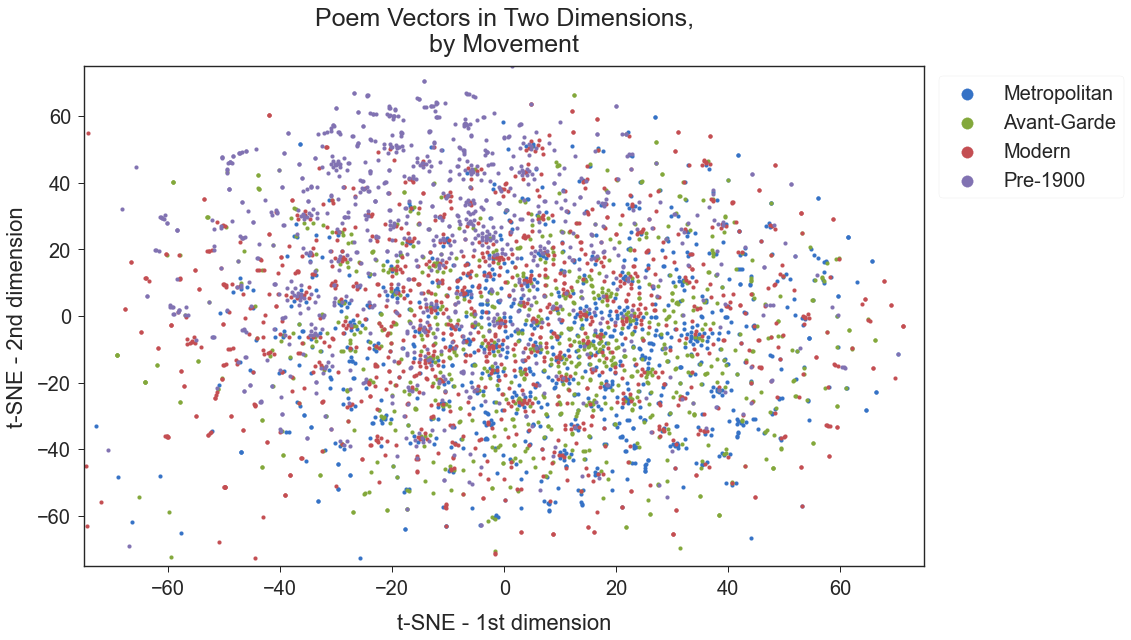

In [26]:
# create a list of all movements
movements = df_poems['movement'].unique()


fig = plt.figure(figsize=(16,9))
# prettify the graph
plt.title('Poem Vectors in Two Dimensions,\nby Movement', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('t-SNE - 1st dimension', fontsize=22, labelpad=15)
plt.ylabel('t-SNE - 2nd dimension', fontsize=22, labelpad=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# iterate through every unique movement and plot with color
ax = plt.subplot(111)
for movement in movements:
    movement_subset = make_tsne_subset(df_tsne, df_poems, 'movement', movement)
    plt.scatter(movement_subset['x'], movement_subset['y'], s=15)

# adjust legend
labels = [m.replace('_', '-').title() for m in movements]
ax.legend(labels, bbox_to_anchor=(1.25,1), markerscale=3, fontsize=20)

# zoom in on great majority of points
plt.xlim((-75,75))
plt.ylim((-75,75))

# prepare to save and display
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tsne_2d_movement.png', 
            bbox_inches='tight', transparent=True)

plt.show()

- Definitely some mini-clusters here and *some* separation between Pre-1900 poetry and the rest.
- Still, a lot of interaction between all of the genres, which doesn't exactly go against my findings in the previous notebooks.

### Two dimensions -- by genre

[[go back to the top](#Predicting-Poetic-Movements)]

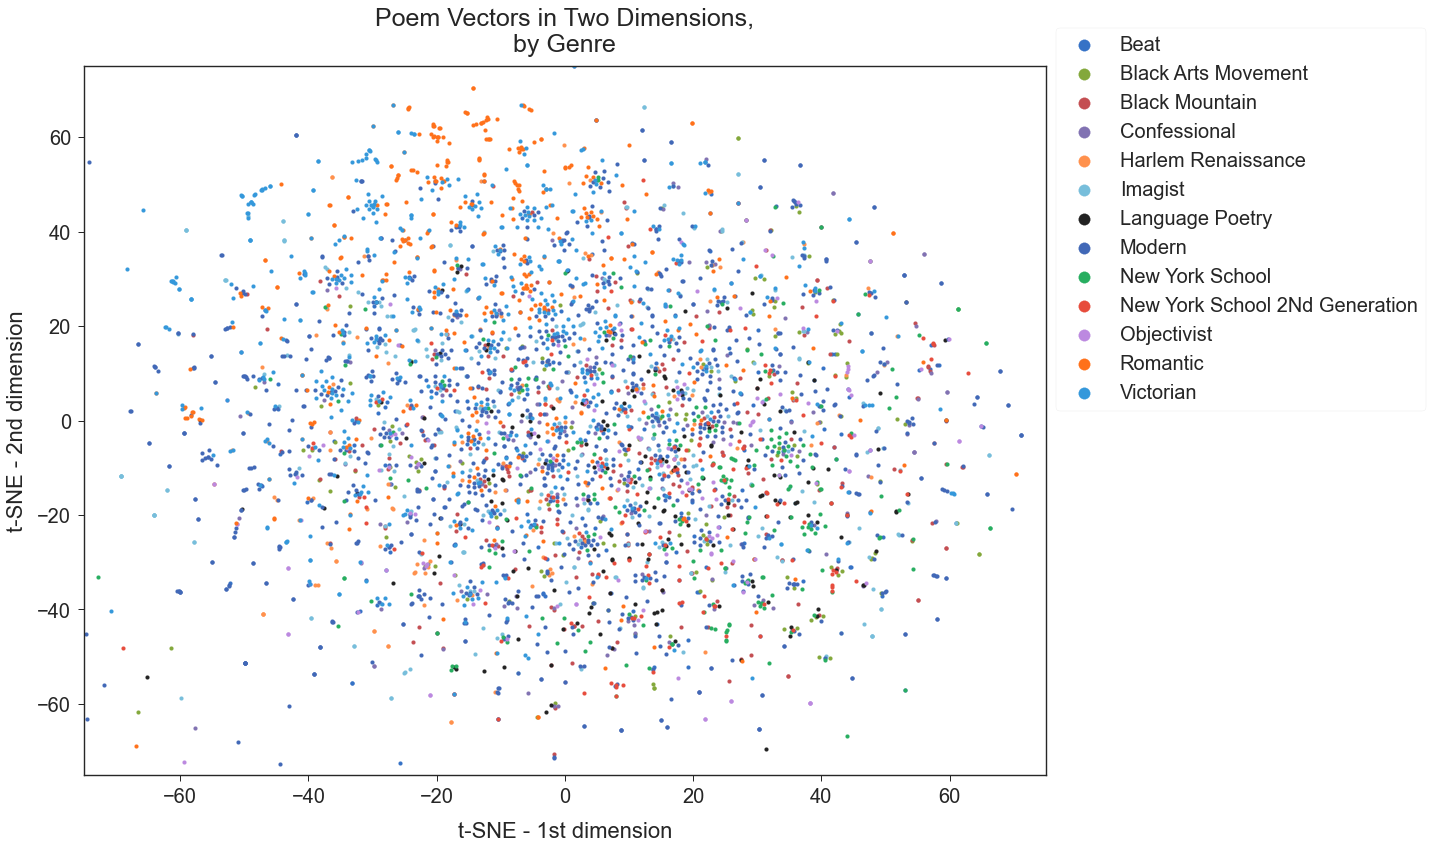

In [27]:
# create a list of all genres
genres = df_poems['genre'].unique()


fig = plt.figure(figsize=(20,12))
# prettify the graph
plt.title('Poem Vectors in Two Dimensions,\nby Genre', 
          fontsize=25, pad=15)
plt.suptitle('')
plt.xlabel('t-SNE - 1st dimension', fontsize=22, labelpad=15)
plt.ylabel('t-SNE - 2nd dimension', fontsize=22, labelpad=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# iterate through every unique genre and plot with color
ax = plt.subplot(111)
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne, df_poems, 'genre', genre)
    plt.scatter(genre_subset['x'], genre_subset['y'], s=15)

# adjust legend
labels = [g.replace('_', ' ').title() for g in genres]
ax.legend(labels, bbox_to_anchor=(1,0.5), markerscale=3, fontsize=20)

# zoom in on great majority of points
plt.xlim((-75,75))
plt.ylim((-75,75))

# prepare to save and display
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tsne_2d_genre.png', 
            bbox_inches='tight', transparent=True)

plt.show()

- Much more difficult to discern separation, not least of which because it seems to have run out of colors.
- Still, some clustering, though definitely more interactions than the graph separating by movement.

## Three dimensions

[[go back to the top](#Predicting-Poetic-Movements)]

- Create 3-dimensional t-SNE object and fit/transform on data.
- Visualize across movement and genre.

In [28]:
%%time

# fit and transform a t-SNE object with the vector data for dimensionality reduction
tsne3 = TSNE(n_components=3,
             perplexity=5,
             learning_rate=100,
             n_iter=1000,
             metric='cosine',
             n_jobs=-1, random_state=42)

X_tsne3 = tsne3.fit_transform(df_docvec)

# convert to dataframe for easy graphing
df_tsne3 = pd.DataFrame(X_tsne3, 
                        index=df_docvec.index, 
                        columns=['x', 'y', 'z'])

CPU times: user 3min 57s, sys: 2.9 s, total: 4min
Wall time: 32.8 s


### Three dimensions -- by movement

[[go back to the top](#Predicting-Poetic-Movements)]

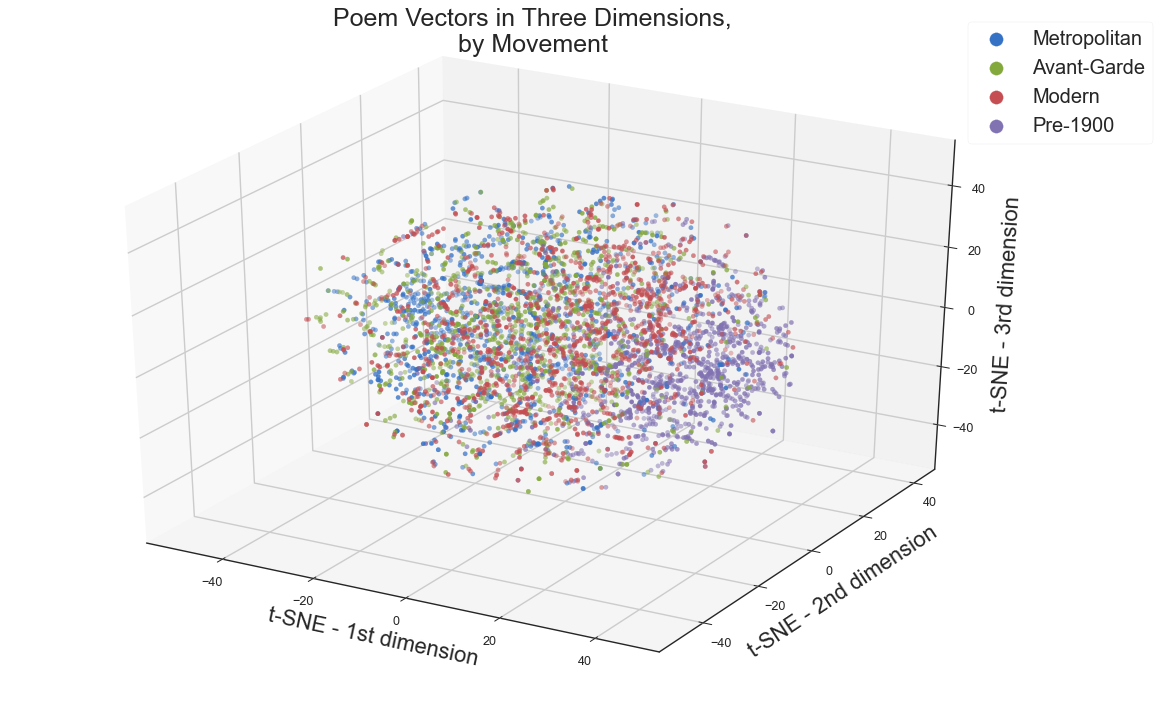

In [29]:
# 3-d graph
ax = plt.figure(figsize=(16,10)).gca(projection='3d')

# title
plt.title('Poem Vectors in Three Dimensions,\nby Movement', 
          fontsize=25, pad=15)

# iterate through every unique movement and plot with color
for movement in movements:
    movement_subset = make_tsne_subset(df_tsne3, df_poems, 'movement', movement)
    ax.scatter(movement_subset['x'], movement_subset['y'], movement_subset['z'], s=20)
    
# axis labels
ax.set_xlabel('t-SNE - 1st dimension', fontsize=22, labelpad=15)
ax.set_ylabel('t-SNE - 2nd dimension', fontsize=22, labelpad=15)
ax.set_zlabel('t-SNE - 3rd dimension', fontsize=22, labelpad=15)

# adjust legend
labels = [m.replace('_', '-').title() for m in movements]
ax.legend(labels, bbox_to_anchor=(1.1,1), markerscale=3, fontsize=20)

# prepare to save and display
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tsne_3d_movement.png', 
            bbox_inches='tight', transparent=True)

plt.show()

- Some pretty decent separation here that fits well with my work during EDA and modeling.
    - Out of the post-1900 movements, Modern is closest to Pre-1900 poetry.
    - The post-1900 movements are fairly jumbled, especially in regard to Avant-Garde and Metropolitan genres.

### Three dimensions -- by genre

[[go back to the top](#Predicting-Poetic-Movements)]

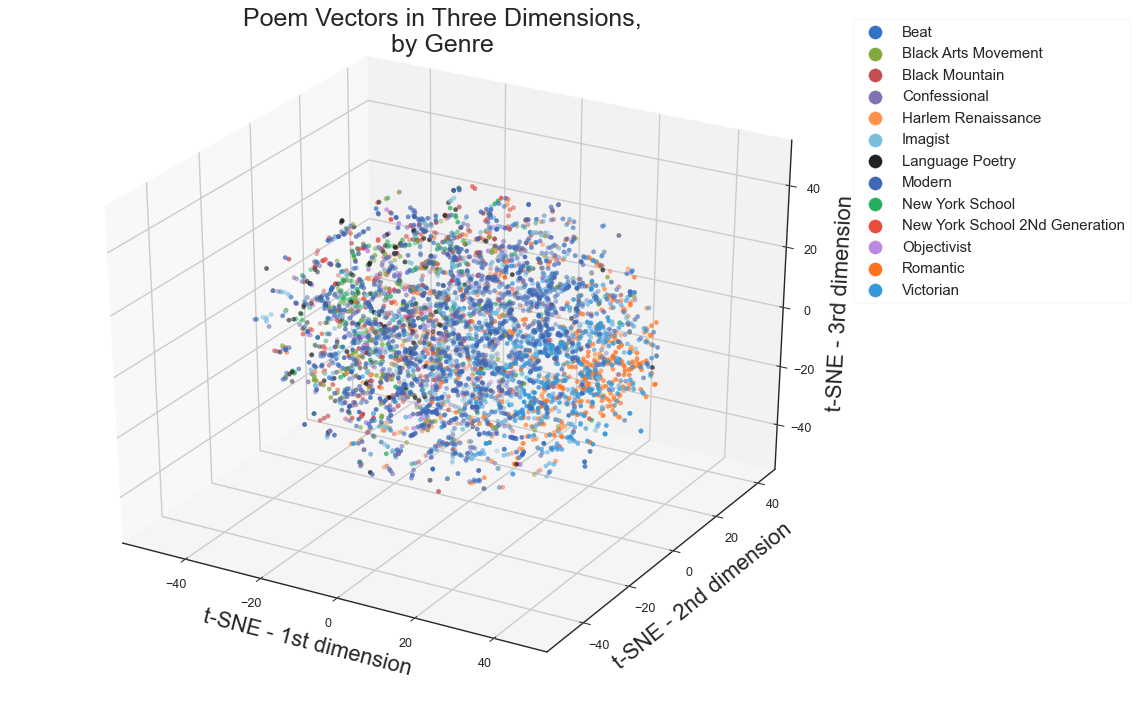

In [30]:
# 3-d graph
ax = plt.figure(figsize=(16,10)).gca(projection='3d')

# title
plt.title('Poem Vectors in Three Dimensions,\nby Genre', 
          fontsize=25, pad=15)

# iterate through every unique movement and plot with color
for genre in genres:
    genre_subset = make_tsne_subset(df_tsne3, df_poems, 
                                    'genre', genre)
    ax.scatter(genre_subset['x'], 
               genre_subset['y'],
               genre_subset['z'], 
               s=20)
    
# axis labels
ax.set_xlabel('t-SNE - 1st dimension', fontsize=22, labelpad=15)
ax.set_ylabel('t-SNE - 2nd dimension', fontsize=22, labelpad=15)
ax.set_zlabel('t-SNE - 3rd dimension', fontsize=22, labelpad=15)

# adjust legend
labels = [g.replace('_', ' ').title() for g in genres]
ax.legend(labels, bbox_to_anchor=(1.3,1), markerscale=3, fontsize=15)

# prepare to save and display
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tsne_3d_genre.png', 
            bbox_inches='tight', transparent=True)

plt.show()

- Fairly indiscernible, though viewing this alongside the graph separated by movement suggests that there is decent enough separation and clustering here.

## Conclusions

[[go back to the top](#Predicting-Poetic-Movements)]

- I was able to build a successful poetry recommender called [PO-REC](https://evening-cove-11137.herokuapp.com/) using the cosine similarity of poem vectors (a combination of my engineered features plus Doc2Vec document embeddings).
- Visualizations using t-SNE appear to have confirmed a lot of my findings during [EDA](03_nlp_features_eda.ipynb) and [modeling](04_modeling.ipynb), namely:
    - Pre-1900 poetry is fairly distinct from the other three movements, although Modern does seem to have the largest overlap.
    - Avant-Garde and Metropolitan poetries share a lot of similarities and are the most distinct from Pre-1900 poetry.
    - All post-1900 movements are prone to being misidentified as one another.
- While fairly obvious, the added difficulty of discerning between specific genres (a future goal for this project) was confirmed using t-SNE visualizations.


## Acknowledgements

[[go back to the top](#Predicting-Poetic-Movements)]

- Thanks to the folks at [PoetryFoundation](https://www.poetryfoundation.org) for publishing poetry for well over a century and making this project possible.
- Thanks to [Sean Abu Wilson](https://github.com/seanabu) and [Fangfang Lee](https://github.com/jessicafangfanglee) for being great teachers.
- Thanks to [Allison Parrish](https://github.com/aparrish) for her [pronouncingpy](https://github.com/aparrish/pronouncingpy) package.
- Thanks to [Sanket Doshi](https://github.com/sdoshi579) for providing the basis for my contraction dictionaries.
- Thanks to [Bryan Bumgardner](https://bryanbumgardner.com/) for his old timey words list.
- Thank you to all the contributors of O'Reilly's [Practical Natural Language Processing repository](https://github.com/practical-nlp/practical-nlp).

- Finally, thanks to [Randal S. Olsen](http://www.randalolson.com/) for providing a great [example](https://nbviewer.jupyter.org/github/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb) of a machine learning notebook.